# Stream processing with Spark

## Outline

This tutorial will teach you the basic of **stream processing with
Spark**. As soon as an application compute something with business value
(for instance customer activity), and new inputs arrive continuously,
companies will want to compute this result continuously too. Spark makes
possible to process stream with the **Structured Streaming API**. This
lab will teach you the basics of this Spark’s API. Because the
Structured Streaming API is based on the DataFrame API most syntaxes of
tutorial 1 are still relevant.

## 1. Spark cluster creation in AWS

⚠️ **DO NOT FORGET TO TURN YOUR CLUSTER OFF A THE END OF THIS
TUTORIAL!**

Instructions are at the beginning of lab 2. Or you can just clone your
cluster

## 2. Notebook configuration

Because Spark Streaming need to write some data on the underlying HDFS
cluster, we need to configure our cluster. The cluster configuration
will be a little bit more complexe than the previous ones. 1. You need
to select a SSH key to your cluster 2. Once you cluster is running, go
to the EC2 dashboard like in lab 0 3. Click on the instance with the
security groups : `ElasticMapReduceEditors-Livy,ElasticMapReduce-master`
4. Go to the security tab 5. Click on the security group
`ElasticMapReduce-master` 6. Clink on edit `inbound rules`
(`Modifier les règles entrantes` en français) 7. Add a rule SSH, to all
IPv4 8. Save your rules 9. Go bask to the EC2 instance with the security
group `ElasticMapReduce-master` 10. Click on `Connect` ( `Se connecter`
en français) 11. Again clik on `Connect` 12. In the cloud shell
copy/paste : `sudo usermod -a -G hdfsadmingroup livy`. It will give to
the the user “livy” admin right.

``` python
# Configuraion
# The user pay the data transfer
spark._jsc.hadoopConfiguration().set("fs.s3.useRequesterPaysHeader","true")

# Set the number of shufflre partitions
spark.conf.set("spark.sql.shuffle.partitions", 5)

# Import all the needed library
from time import sleep
from pyspark.sql.functions import from_json, window, col, expr, size, explode, avg, min, max
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, TimestampType, BooleanType, LongType, DoubleType
```

**Explanation:**

-   `spark._jsc.hadoopConfiguration().set("fs.s3.useRequesterPaysHeader","true")`
    : likes in lab2, you will be charged for the data transfer. without
    this configuration you can’t access the data.

-   `spark.conf.set("spark.sql.shuffle.partitions", 5)` : set the number
    of partitions for the shuffle phase. A partition is in Spark the
    name of a bloc of data. By default Spark use 200 partitions to
    shuffle data. But in this lab, our mini-batch will be small, and to
    many partitions will lead to performance issues.

        spark.conf.set("spark.sql.shuffle.partitions", 5)

    > 🤔 The shuffle dispatches data according to their key between a
    > *map* and a *reduce* phase. For instance, if you are counting how
    > many records have each `g` group, the *map* phase involve counting
    > each group member in each Spark partition :
    > `{g1:5, g2:10, g4:1, g5:3}` for one partition,
    > `{g1:1, g2:2, g3:23, g5:12}` for another. The *shuffle* phase
    > dispatch those first results and group them by key in the same
    > partition, one partition gets `{g1:5, g1:1, g2:10, g2:2}`, the
    > other gets : `{g4:1, g5:3, g3:23, g5:12}` Then each *reduce* can
    > be done efficiently.

-   📦 Import all needed library

    ``` python
    from time import sleep
    from pyspark.sql.functions import from_json, window, col, expr
    from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, TimestampType, BooleanType, LongType, DoubleType
    ```

## 3. Stream processing

Stream processing is the act to process data in real-time. When a new
record is available, it is processed. There is no real beginning nor end
to the process, and there is no “result”. The result is updated in real
time, hence multiple versions of the results exist. For instance, you
want to count how many tweet about cat are posted in twitter every hour.
Until the end of an hour, you do not have you final result. And even at
this moment, your result can change. Maybe some technical problems
created some latency and you will get some tweets later. And you will
need to update your previous count.

Some commons use cases of stream processing are :

-   **Notifications and alerting :** real-time bank fraud detection ;
    electric grid monitoring with smart meters ; medical monitoring with
    smart meters, etc.
-   **Real time reporting:** traffic in a website updated every minute;
    impact of a publicity campaign ; stock option portfolio, etc.
-   **Incremental ELT (extract transform load):** new unstructured data
    are always available and they need to be processed (cleaned,
    filtered, put in a structured format) before their integration in
    the company IT system.
-   **Online machine learning :** new data are always available and used
    by a ML algorithm to improve its performance dynamically.

Unfortunately, stream processing has some issues. First because there is
no end to the process, you cannot keep all the data in memory. Second,
process a chain of event can be complex. How do you raise an alert when
you receive the value 5, 6 and 3 consecutively ? Don’t forget you are in
a distributed environment, and there is latency. Hence, the received
order can be different from the emitted order.

## 4. Spark and stream processing

Stream processing was gradually incorporated in Spark. In 2012 Spark
Streaming and it’s DStreams API was added to Spark (it was before an
external project). This made it possible use high-level operator like
`map` and `reduce` to process stream of data. Because of its
implementation, this API has some limitations, and its syntax was
different from the DataFrame one. Thus, in 2016 a new API was added, the
Structured Streaming API. This API is directly build built on DataFrame,
unlike DStreams. **This has an advantage, you can process your stream
like static data**. Of course there are some limitations, but the core
syntaxes is the same. You will chain transformations, because each
transformation takes a DataFrame as input and produces a DataFrame as
output. The big change is there is no action at the end, but an
**[output sink](#2.2%20How%20to%20output%20a%20stream%20?)**.

<figure>
<img
src="https://databricks.com/wp-content/uploads/2016/07/image01-1.png"
alt="data stream" />
<figcaption aria-hidden="true">data stream</figcaption>
</figure>

*Figure 1 : data stream representation (source [structured streaming
programming
guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#basic-concepts))*

Spark offer two ways to process stream, one **record at a time**, or
processing **micro batching** (processing a small amount of line at
once).

-   **one record at a time** every time a new record is available it’s
    processed. This has a big advantage, it achieves **very low latency
    **. But there is a drawback, the system can not handle too much data
    at the same time (low throughput). It’s the default mode. Because in
    this lab, you will process files with record, even if you will
    process one file at a time, you will process mini batch of records
-   as for **micro batching** it process new records every `t` seconds.
    Hence records are not process really in “real-time”, but
    periodically, **the latency will be higher, and so the throughput**.
    Unless you really need low latency, make it you first choice option.

> 🧐 To get the best ratio latency/throughput, a good practice is to
> decrease the micro-batch size until the mini-batch throughput is the
> same as the input throughput. Then increase the size to have some
> margin

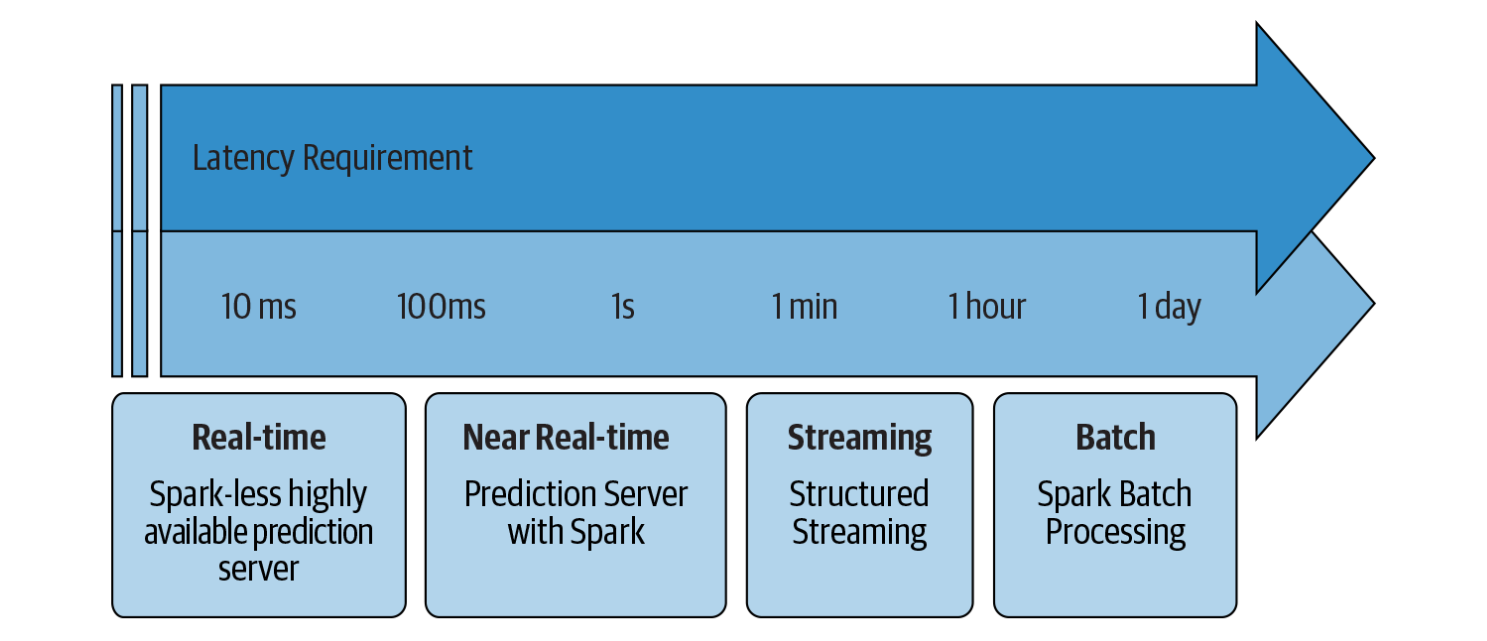

*Figure 2 : which Spark solution suit best giving latency requirement
(source : [Learning Spark,
O’Reilly](https://pages.databricks.com/rs/094-YMS-629/images/LearningSpark2.0.pdf))*

> To understand why processing one record at a time has lower latency
> and throughput than batch processing, imagine a restaurant. Every time
> a client order something the chef cooks its order independently of the
> other current orders. So if two clients order pizza, the chief makes
> two small doughs, and cook them individually. If clients there is only
> a few clients, the chief can finish each order before a new client
> comes. The latency is the lowest possible when the chief is idle when
> a client come. Know imagine a restaurant were the chief process the
> orders by batch. He waits some minutes to gather all the orders than
> he mutualizes the cooking. If there are 5 pizza orders, he only does
> one big dough, divides it in five, add the toppings then cook all five
> at once. The latency is higher because the chief waits before cooking,
> but so the throughput because he can cook multiple things at once.

## 5. The basics of Spark’s Structured Streaming

### 5.1. The different sources for stream processing in Spark

In lab 2 you discovered Spark DataFrame, in this lab you will learn
about [Structured
Streaming](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html).
It’s a stream processing framework built on the Spark SQL engine, and it
uses the existing structured APIs in Spark. So one you define a way to
read a stream, you will get a DataFrame. Like in lab2 ! **So except
state otherwise, all transformations presented in lab2 are still
relevant in this lab**.

Spark Streaming supports several input source for reading in a streaming
fashion :

-   [Apache Kafka](https://kafka.apache.org/) an open-source distributed
    event streaming platform (not show in this lab)
-   Files on distributed file system like HDFS or S3 (Spark will
    continuously read new files in a directory)
-   A network socket : an end-point in a communication across a network
    (sort of very simple webservice). It’s not recommend for
    *production* application, because a socket connection doesn’t
    provide any mechanism to check the consistency of data.

Defining an input source is like loading a DataFrame but, you have to
replace `spark.read` by `spark.readStream`. For instance, if I want to
open a stream to a folder located in S3 you have to read every new files
put in it, just write

``` python
my_first_stream = spark\
.readStream\
.schema(schema_tweet)\
.json("s3://my-awesome-bucket/my-awesome-folder")
```

The major difference with lab2, it is Spark cannot infer the schema of
the stream. You have to pass it to Spark. There is two ways :

-   A reliable way : you define the schema by yourself and gave it to
    Spark
-   A quick way : you load one file of the folder in a DataFrame,
    extract the schema and use it. It works, but the schema can be
    incomplete. It’s a better solution to create the schema by hand and
    use it.

For Apache Kafka, or socket , it’s a slightly more complex, *(not used
today, it’s jute for you personal knowledge)* :

``` python
my_first_stream = spark\
.readStream\
.format("kafka")
.option("kafka.bootstrat.servers", "host1:port1, host2:port2 etc")
.option("subscribePattern", "topic name")
.load()
```

#### 5.1.1 Why is a folder a relevant source in stream processing ?

Previously, in lab 1, you loaded all the files in a folder stored in S3
with Spark. And it worked pretty well. But this folder was static, in
other words, Its content didn’t change. But in some cases, new data are
constantly written into a folder. For instance, in this lab you will
process a stream of tweets. A python script is running in a EC2 machine
reading tweets from the Twitter’s web service and writing them in a S3
buckets. Every 2 seconds or so, a new file is added to the bucket with
1000 tweets. If you use DataFrame like in lab 1, your process cannot
proceed those new files. You should relaunch your process every time.
But with Structured Streaming Spark will dynamically load new files.

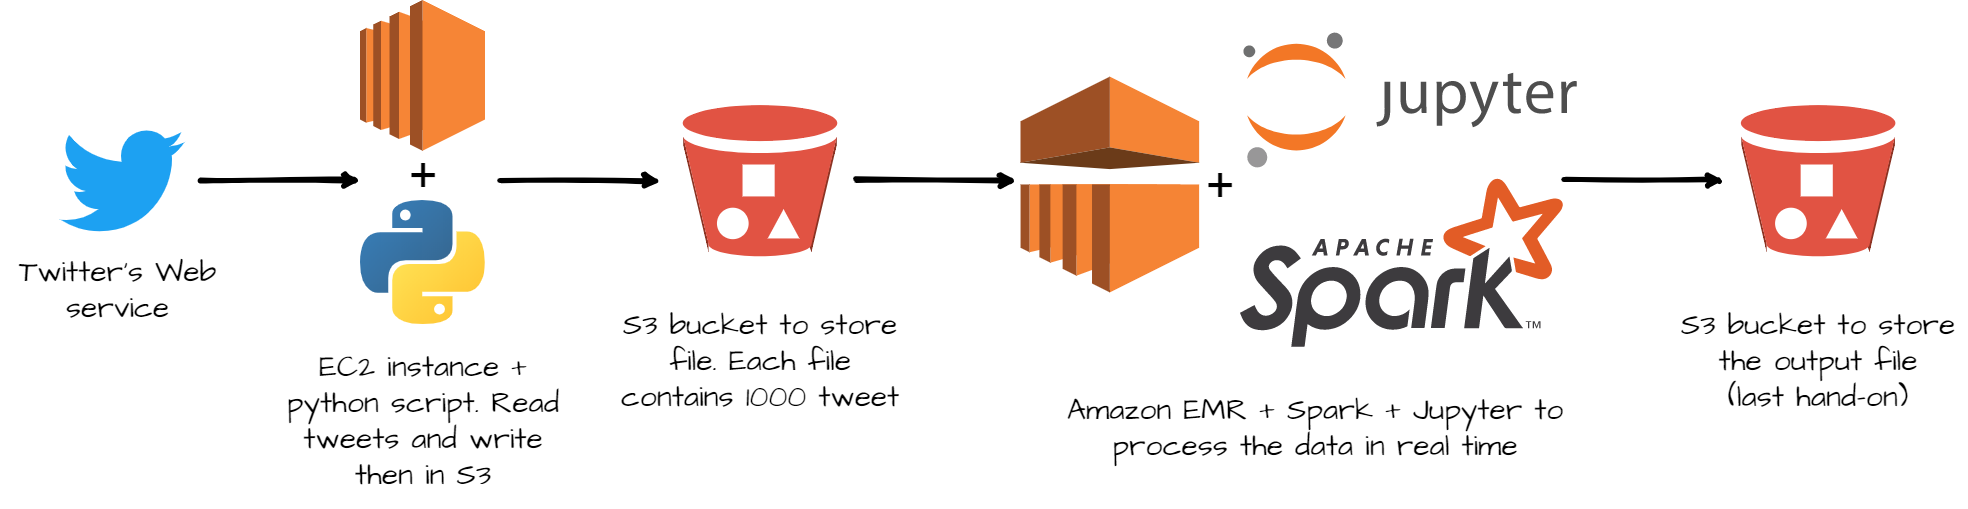

*Figure 3 : Complete lab architecture to stream process tweets*

> The remaining question is, why don’t we connect Spark to the twitter
> webservice directly ? And the answer is : we can’t. Spark cannot be
> connected to a webservice directly. You need a middle-man between
> Spark and a webservice. There are multiple solutions, but an easy and
> reliable one is to write tweet to s3 (because we use AWS services, if
> you use Microsoft Azure, Google Cloud Platform or OVH cloud replace S3
> by their storage service).

### ✍ Open a stream

Like in lab 1, you will use tweets in this lab. The tweets are stored in
jsonl file (*json line* every line of the file is a complete json). Here
is an example. The schema changed a little, because this time tweets
aren’t pre-processed.

``` js
{
    "data": {
        "public_metrics": {
            "retweet_count": 0,
            "reply_count": 0,
            "like_count": 0,
            "quote_count": 0
        },
        "text": "Day 93. Tweeting every day until Colby cheez its come back #bringcolbyback @cheezit",
        "possibly_sensitive": false,
        "created_at": "2021-05-03T07:55:46.000Z",
        "id": "1389126523853148162",
        "entities": {
            "annotations": [
                {
                    "start": 33,
                    "end": 43,
                    "probability": 0.5895,
                    "type": "Person",
                    "normalized_text": "Colby cheez"
                }
            ],
            "mentions": [
                {
                    "start": 75,
                    "end": 83,
                    "username": "cheezit"
                }
            ],
            "hashtags": [
                {
                    "start": 59,
                    "end": 74,
                    "tag": "bringcolbyback"
                }
            ]
        },
        "lang": "en",
        "source": "Twitter for iPhone",
        "author_id": "606856313"
    },
    "includes": {
        "users": [
            {
                "created_at": "2012-06-13T03:36:00.000Z",
                "username": "DivinedHavoc",
                "verified": false,
                "name": "Justin",
                "id": "606856313"
            }
        ]
    }
}
```

-   Define a variable with this schema (you will find a file *schema
    pyspark tweet* on moodle with the schema to copy /aste)

    ``` python
    from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, TimestampType, BooleanType, LongType, DoubleType

    StructType([
      StructField("data", StructType([
          StructField("author_id",StringType(),True),
          StructField("text",StringType(),True),
          StructField("source",StringType(),True),
          StructField("lang",StringType(),True),
          StructField("created_at",TimestampType(),True),
          StructField("entities",StructType([
              StructField("annotations", ArrayType(StructType([
                  StructField("end", LongType(), True),
                  StructField("normalized_text", StringType(), True),
                  StructField("probability", DoubleType(), True),
                  StructField("start", LongType(), True),
                  StructField("type", StringType(), True)
              ]),True),True),
              StructField("cashtags", ArrayType(StructType([
                  StructField("end", LongType(), True),
                  StructField("start", LongType(), True),
                  StructField("tag", StringType(), True)
              ]),True),True),
               StructField("hashtags", ArrayType(StructType([
                  StructField("end", LongType(), True),
                  StructField("start", LongType(), True),
                  StructField("tag", StringType(), True)
              ]),True),True),
              StructField("mentions", ArrayType(StructType([
                  StructField("end", LongType(), True),
                  StructField("start", LongType(), True),
                  StructField("username", StringType(), True)
              ]),True),True),
              StructField("urls", ArrayType(StructType([
                  StructField("description", StringType(), True),
                  StructField("display_url", StringType(), True),
                  StructField("end", LongType(), True),
                  StructField("expanded_url", StringType(), True),
                  StructField("images", ArrayType(StructType([
                          StructField("height", LongType(), True),
                          StructField("url", StringType(), True),
                          StructField("width", LongType(), True)
                      ]),True),True),
                  StructField("start", LongType(), True),
                  StructField("status", LongType(), True),
                  StructField("title", StringType(), True),
                  StructField("unwound_url", StringType(), True),
                  StructField("url", StringType(), True),
              ]),True),True),
          ]),True),
          StructField("public_metrics", StructType([
              StructField("like_count", LongType(), True),
              StructField("reply_count", LongType(), True),
              StructField("retweet_count", LongType(), True),
              StructField("quote_count", LongType(), True),
          ]),True)
        ]),True),
      StructField("includes", StructType([
          StructField("users", ArrayType(StructType([
              StructField("created_at", TimestampType(), True),
              StructField("id", StringType(), True),
              StructField("name", StringType(), True),
              StructField("username", StringType(), True),
              StructField("verified", BooleanType(), True)
          ]),True),True)
      ]),True)
      ])
    ```

-   Crate a stream to this s3 bucket :
    `s3://spark-lab-input-data-ensai20212022/stream_tweet/`. Name it
    `tweet_stream`

    > 🤔 Nothing happen ? It’s normal ! Do not forget, Spark use lazy
    > evaluation. It doesn’t use data if you don’t define an action. For
    > now Spark only know how to get the stream, that’s all.

-   In a cell just execute `tweet_stream`. It should print the type of
    `tweet_stream` and the associated schema. You can see you created a
    DataFrame like in lab2 !

-   To print the size of your DataFrame with this piece of code :

    ``` python
    stream_size_query= tweet_stream\
    .writeStream\
    .queryName("stream_size")\
    .format("memory")\
    .start()

    for _ in range(10): # we use an _ because the variable isn't used. You can use i if you prefere
        sleep(3)
        spark.sql("""
          SELECT count(1) FROM stream_size
        """).show()
    stream_size_query.stop() #needed to close the query
    ```

### 5.2 How to output a stream ?

Remember, Spark has two types of methods to process DataFrame:

-   Transformations which take a DataFrame has input and produce an
    other Dataframe
-   And actions, which effectively run computation and produce
    something, like a file, or a output in you notebook/console.

Stream processing looks the same as DataFrame processing. Hence, **you
still have transformations**, the exact same one that can be apply on
classic DataFrame (with some restriction, for example you can not sample
a stream with the `sample()` transformation). The action part is a
little different. Because a stream runs continuously, you cannot just
print the data or run a count at the end of the process. **In fact
actions will nor work on stream**. To tackle this issue, Spark proposes
different [outputs
sinks](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-sinks).
An output sink is a possible output for your stream. The different
output sink are (this part came from the official Spark
[documentation)](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#output-sinks)
:

-   **File sink** - Stores the output to a file. The file can be stored
    locally (on the cluster), remotely (on S3). The file format can be
    json, csv etc

``` python
writeStream\
.format('json')\
.option("checkpointLocation", "output_folder/history") \
.option("path", "output_folder")\
.start()
```

-   **Kafka sink** - Stores the output to one or more topics in Kafka.

-   **Foreach sink** - Runs arbitrary computation on the records in the
    output. It does not produce an DataFrame. Each processed lines lost

``` python
writeStream
    .foreach(...)
    .start()
```

-   **Console sink (for debugging)** - Prints the output to the console
    standard output (*stdout*) every time there is a trigger. This
    should be used for debugging purposes on low data volumes as the
    entire output is collected and stored in the driver’s memory after
    every trigger. *Sadly console sink does not work with jupyter
    notebook*.

``` python
writeStream
    .format("console")
    .start()
```

-   **Memory sink (for debugging)** - The output is stored in memory as
    an in-memory table. This should be used for debugging purposes on
    low data volumes as the entire output is collected and stored in the
    driver’s memory. Hence, use it with caution. Because we are in a
    simple lab, you will use this solution. But keep in mind it’s a very
    bad idea because data must fit in the the ram of the driver node.
    And in a big data context it’s impossible. Because it’s not a big
    data problem if one computer can tackle it.

``` python
writeStream
    .format("memory")
    .queryName("tableName") # to resquest the table with spark.sql()
    .start()
```

We just talked where we can output a stream, but there is another
question, how ?

To understand why it’s a issue, let’s talk about two things that spark
can do with streams : filter data and group by + aggregation

-   **Filter** : your process is really simple. Every time you get a new
    data you just compute a score and drop records with a score less
    than a threshold. Then you write into a file every kept record. In a
    nutshell, you just append new data to a file. Spark does not have to
    read an already written row, it just add new data.
-   **Group by + aggregation** : in this case you want to group by your
    data by key than compute a simple count. Then you want to write the
    result in a file. But now there is an issue, Spark needs to update
    some existing rows in your file every time it writes somethings. But
    is your file is stored in HDFS of S3, it’s impossible to update in a
    none append way a file. In a nutshell, it’s impossible to output in
    a file your operation.

To deal with this issue, Spark proposes 3 mode. **And you cannot use
every mode with every output sink, with every transformation**. The 3
modes are ([more info
here](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#starting-streaming-queries))
:

-   **Append mode (default)** - This is the default mode, where only the
    new rows added to the Result Table since the last trigger will be
    outputted to the sink. This is supported for only those queries
    where rows added to the Result Table is never going to change.
    Hence, this mode guarantees that each row will be output only once
    (assuming fault-tolerant sink). For example, queries with only
    `select`, `where`, `map`, `flatMap`, `filter`, `join`, etc. will
    support Append mode.
-   **Complete mode** - The whole Result Table will be outputted to the
    sink after every trigger. This is supported for aggregation queries.
-   **Update mode** - (*Available since Spark 2.1.1*) Only the rows in
    the Result Table that were updated since the last trigger will be
    outputted to the sink. More information to be added in future
    releases.

| Sink                  | Supported Output Modes   |
|-----------------------|--------------------------|
| **File Sink**         | Append                   |
| **Kafka Sink**        | Append, Update, Complete |
| **Foreach Sink**      | Append, Update, Complete |
| **ForeachBatch Sink** | Append, Update, Complete |
| **Console Sink**      | Append, Update, Complete |
| **Memory Sink**       | Append, Complete         |

### 5.3 How to output a stream : summary

To sum up to output a stream you need

-   DataFrame (because once load a stream is a DataFrame)
-   A format for your output, like console to print in console, memory
    to keep the Result Table in memory, json to write it to a file etc
-   A mode to specify how the Result Table will be updated.

For instance for the memory sink

``` python
memory_sink = df\
.writeStream\
.queryName("my_awesome_name")\
.format('memory')\
.outputMode("complete" or "append")\
.start() #needed to start the stream
```

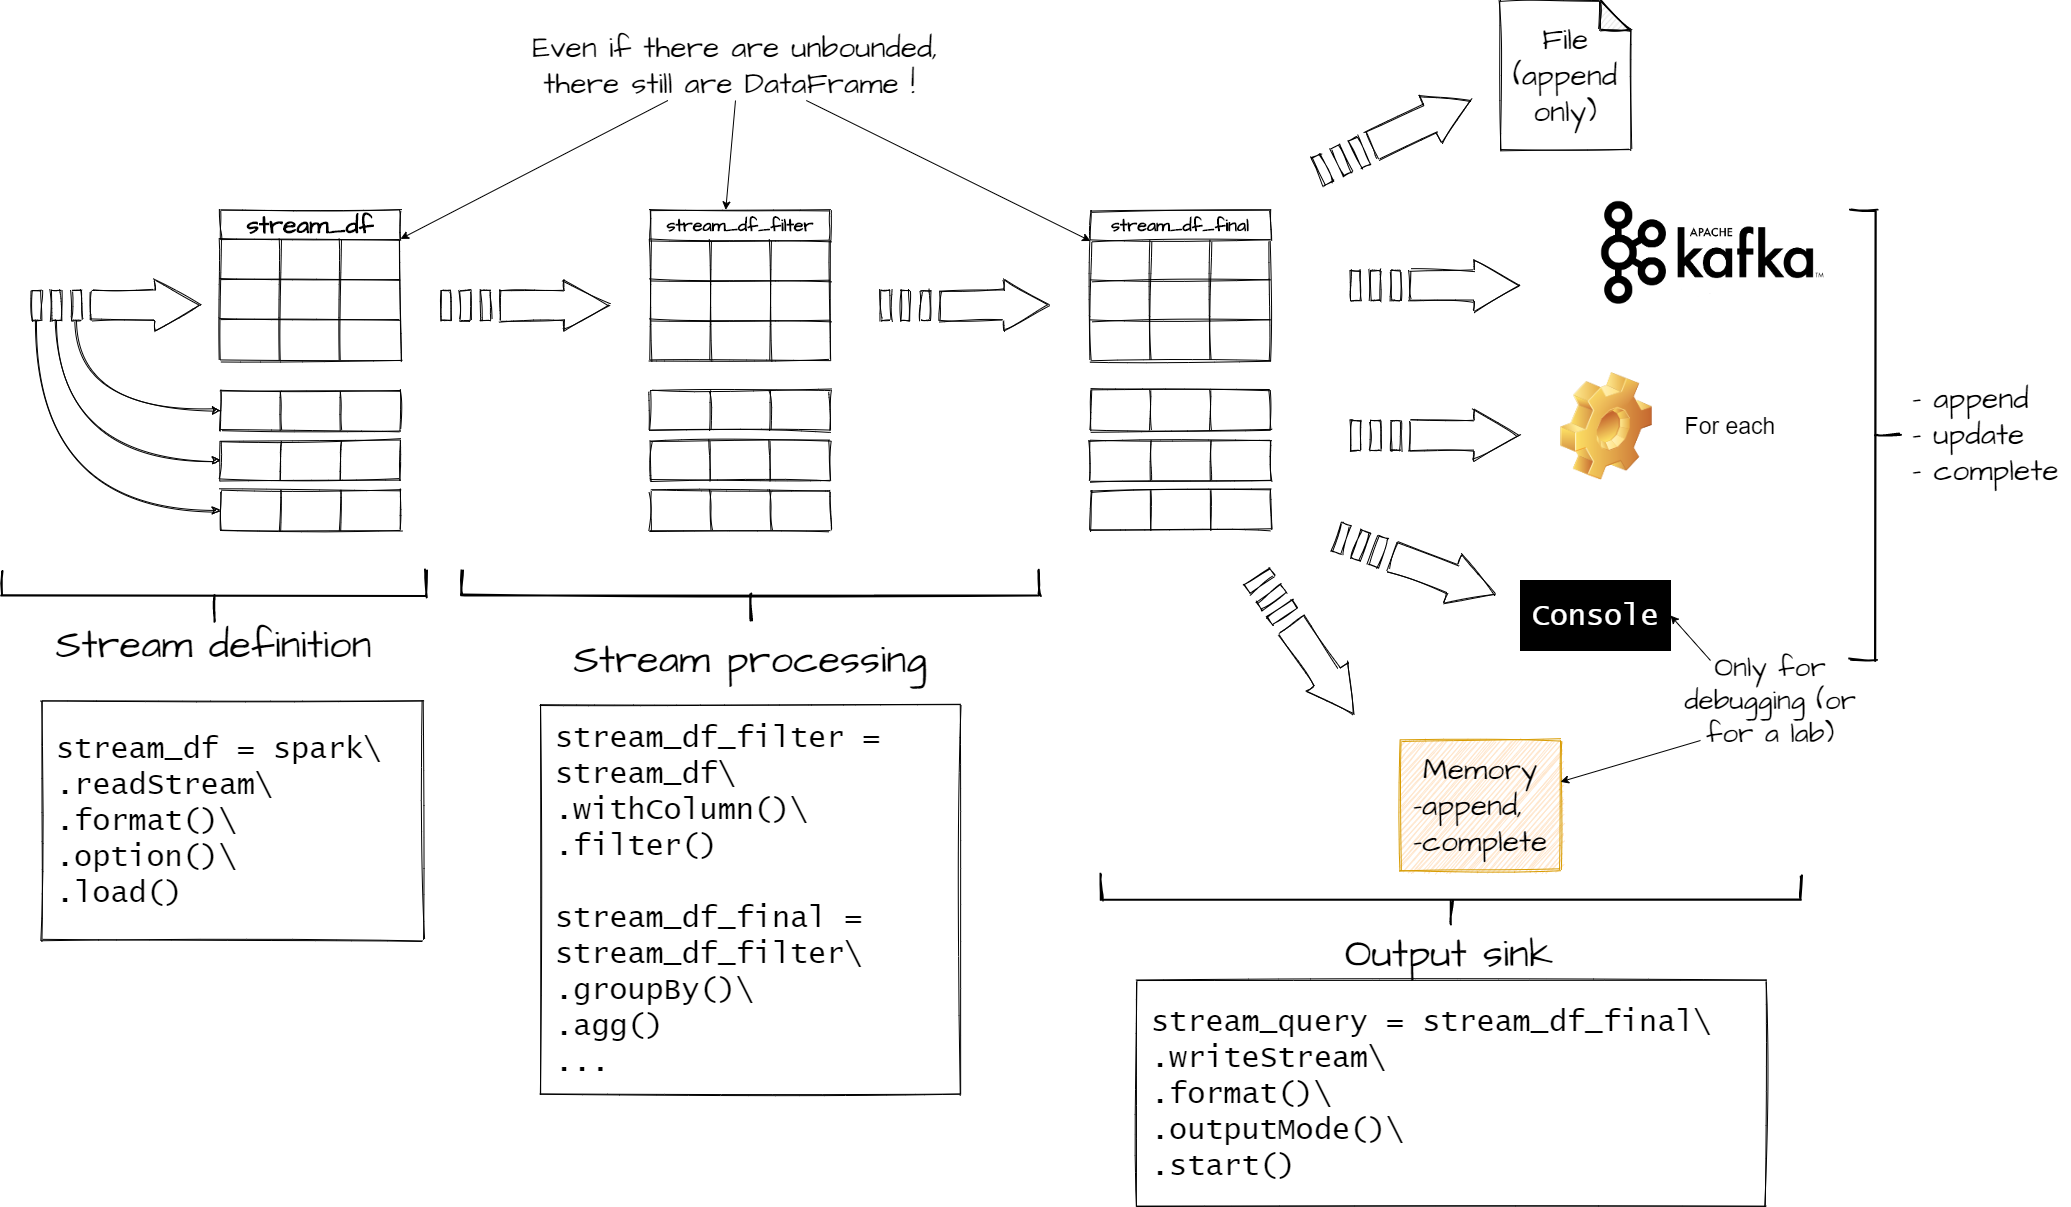

*Figure 4 : The different phases of stream processing in Spark*

### ✍ Output a stream

#### Lang count

-   Compute a DataFrame that group and count data by the `lang` column.
    Name your DataFrame `lang_count`

-   Use this DataFrame to create a output stream with the following
    configuration :

    -   Names the variable `lang_query`
    -   Memory sink
    -   Complete mode (because we are doing an agregation)
    -   Name you query `lang_count`

-   Then past this code

    ``` python
    for _ in range(10): # we use an _ because the variable isn't use. You can use i if you prefere
        sleep(3)
        spark.sql("""
        SELECT * FROM lang_count""").show()
    lang_query.stop() #needed to close the stream
    ```

    After 30 seconds, 10 tables will appeared in your notebook. Each
    table represents the contain of `lang_count` at a certain time. The
    `.stop()` method close the stream.

    In the rest of this tutorial, to will need two steps to print data :

    1.  Define a stream query with a memory sink
    2.  Request this stream with the `spark.sql()` function

    Instead of a for loop, you can just write you `spark.sql()`
    statement in a cell and rerun it. In this case you will need a third
    cell with a `stop()` method to close your stream.

    For instance:

-   Cell 1
    `python       my_query = my_df\           .writeStream\           .format("memory")\           .queryName("query_table")\           .start()`

-   Cell 2 `python       spark.sql("SELECT * FROM query_table").show()`

-   Cell 3 `python       my_query.stop()`

\#### ❌ Count tweets with and without hashtag

-   Add a column `has_hashtag` to your DataFrame. This column equals
    True if `data.entities.hashtags` is not null. Else it’s false. Use
    the `withColumn` transformation to add a column. You can count the
    size of `data.entities.hashtags` to check if it’s empty or not.
-   Group and count by the `has_hashtag` column
-   Print some results

### Debugging tip

If at any moment of this lab you encounter an error like this one :

    'Cannot start query with name has_hashtag as a query with that name is already active'
    Traceback (most recent call last):
      File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/streaming.py", line 1109, in start
        return self._sq(self._jwrite.start())
      File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
        answer, self.gateway_client, self.target_id, self.name)
      File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 79, in deco
        raise IllegalArgumentException(s.split(': ', 1)[1], stackTrace)
    pyspark.sql.utils.IllegalArgumentException: 'Cannot start query with name has_hashtag as a query with that name is already active'

Run in a cell the following code :

``` python
for stream in spark.streams.active:
    stream.stop()
```

`spark.streams.active` returns an array with all the active stream, and
the code loops over all the active stream and closes them.

## 6. Stream processing basics

### ✍ Transformations on stream

-   🔪 Filter all records with missing / null value then count how many
    records you keep

    -   For this filter, you will use the `na.drop("any")`
        transformation. The `na.drop("any")` drop every line with a null
        value in at least one column. It’s simpler than using a
        `filter()` transformation because you don’t have to specify all
        the column. For more precise filter you can use
        `na.drop("any" or "all", subset=list of col)` (`all` will drop
        rows with only null value in all columns or in the specified
        list).
    -   Use the SQL `COUNT(1)` function in the sql request to get the
        count
    -   Because you don’t perform aggregation the `outputMode()` must be
        `append`

    You will notice no record are dropped.

-   🕵️‍♂️ Drop all records with unverified
    (`includes.users.verified == True`)user then group the remaining
    records by `hashtag`.

    -   `includes.users` is an array with only one element. You will
        need to extract it.
    -   `data.entities.hashtags` is an array too ! To group by tag (the
        hashtag content) you will need to explode it too.

-   🔻 Find ukraine related tweet (or any other topic like cat, dog,
    spring, batman, dogecoin etc) :

    -   Define a new column, name `ukraine_related`. This column is
        equal to `True` if `data.text` contains “ukraine”, else it’s
        equal to`False`.

    -   Use the `withColumn()` transformation, and the `expr()` function
        to define the column. `expr()` takes as input an SQL expression.
        You do not need a full SQL statement
        (`SELECT ... FROM ... WHERE ...`) but just an SQL expression
        that return True or False if `data.text` contains “ukraine”. To
        help you :

    -   `LOWER()` put in lower case a string

    -   `input_string LIKE wanted_string` return `True` if
        `input_string` is equal to `wanted_string`

    -   You can use `%` as wildcards

    [For more help](https://www.w3schools.com/sql/sql_like.asp)

    -   Only keep `data.text`, `data.lang`, `data.public_metrics` and
        `data.created_at`

### ✍ Aggregation and grouping on stream

-   Count the number of different hashtag.

-   Group by hashtag and compute the average, min and max of
    `like_count`

    -   Use the `groupBy()` and `agg()` transformations

-   Compute the average of `like_count`, `retweet_count` and
    `quote_count` :

    -   across all `hashtag` and `lang`
    -   for each `lang` across all `hashtag`
    -   for each `hashtag` across all `lang`
    -   for each `hashtag` and each `lang`

    To do so, replace the `groupBy()` transformation by the `cube()`
    one. `cube()` group compute all possible cross between dimensions
    passed as parameter. You will get something like this

    | hashtag | lang | avg(like_count) | avg(retweet_count) | avg(quote_count) |
    |---------|------|-----------------|--------------------|------------------|
    | cat     | null | 1               | 2                  | 3                |
    | dog     | null | 4               | 5                  | 6                |
    | …       | …    | …               | …                  | …                |
    | bird    | fr   | 7               | 8                  | 9                |
    | null    | en   | 10              | 11                 | 12               |
    | null    | null | 13              | 14                 | 15               |

    A `null` value mean this dimension wasn’t use for this row. For
    instance, the first row gives the averages when `hashtag==cat`
    independently of the `lang`. The before last row gives averages when
    `lang==en` independently of the `hashtag`. And the last row gives
    the averages for the full DataFrame.

## 7. Event-time processing

Event-time processing consists in processing information with **respect
to the time that it was created, not received**. It’s a hot topic
because sometime you will receive data in an order different from the
creation order. For example, you are monitoring servers distributed
across the globe. Your main datacentre is located in Paris. Something
append in New York, and a few milliseconds after something append in
Toulouse. Due to location, the event in Toulouse is likely to show up in
your datacentre before the New York one. If you analyse data bases on
the received time the order will be different than the event time.
Computers and network are unreliable. Hence, when temporality is
important, you must consider the creation time of the event and not it’s
received time.

Hopefully, Spark will handle all this complexity for you ! If you have a
timestamp column with the event creation spark can update data
accordingly to the event time.

For instance is you process some data with a time window, Spark will
update the result based on the event-time not the received time. So
previous windows can be updated in the future.

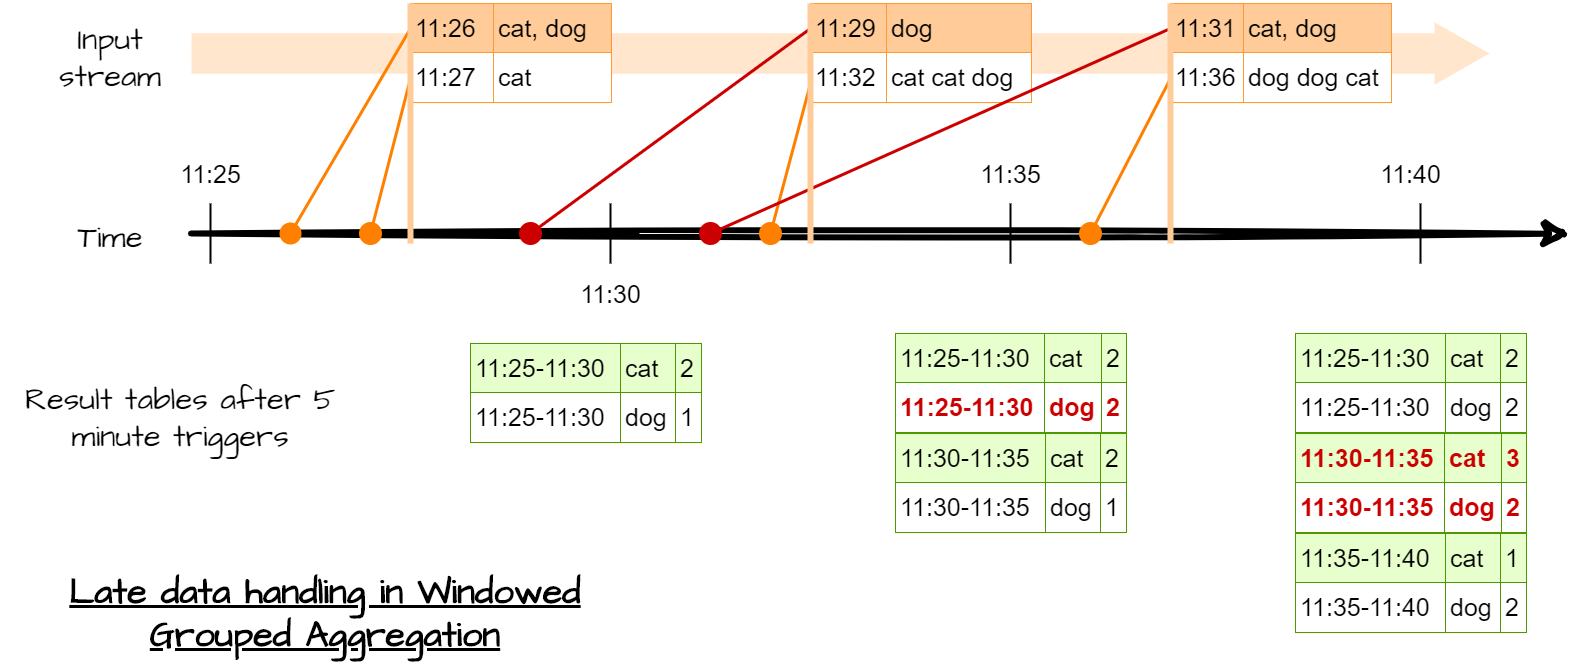

*Figure 5 : Time-event processing, event grouped by time windows*

To work with time windows, Spark offers two type of windows

-   Normal windows. You only consider event in a given windows. All
    windows are disjoint, and a event is only in one window.
-   Sliding windows. You have a fix window size (for example 1 hour) and
    a trigger time (for example 10 minute). Every 10 minute, you will
    process the data with an event time less than 1h.

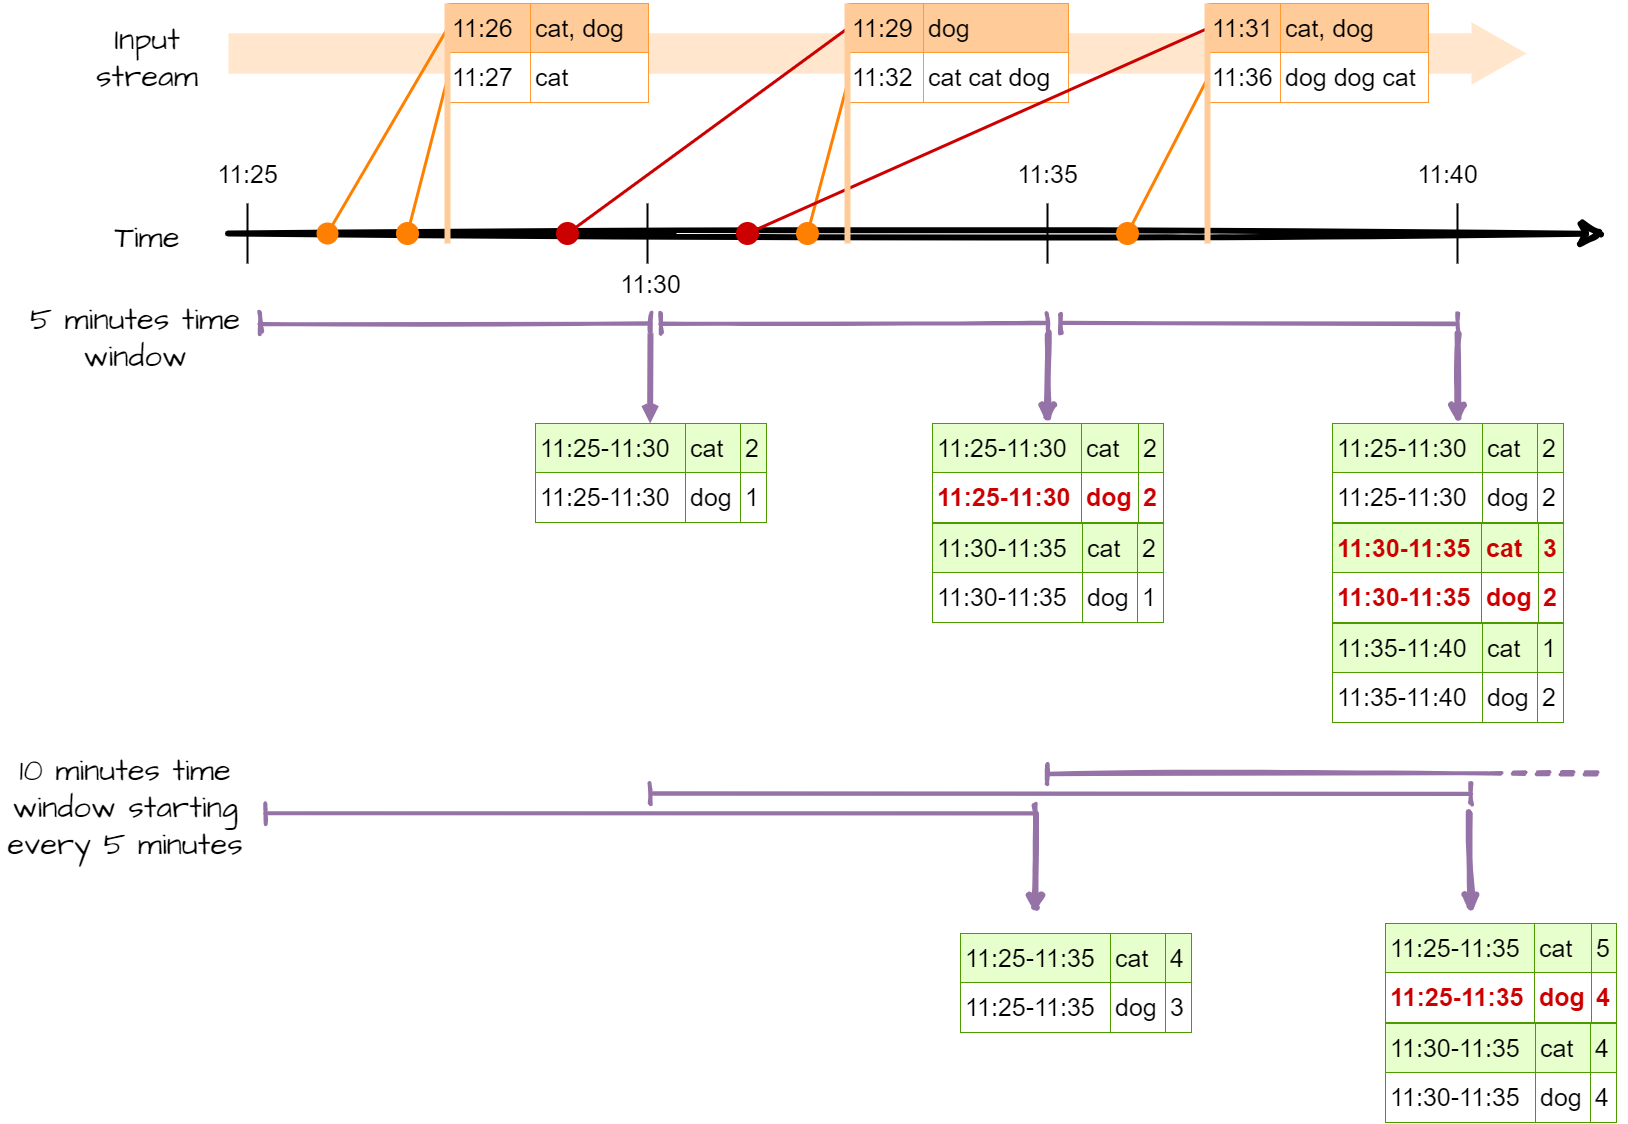

*Figure 6 : Time-event processing, event grouped by sliding time
windows*

To create time windows, you need :

-   to define a time window :
    `window(column_with_time_event : str or col, your_time_window : str, timer_for_sliding_window) : str`

-   grouping row by event-time using your window :
    `df.groupeBy(window(...))`

To produce the above processes :

``` python
# Need some import
from pyspark.sql.functions import window, col

# word count + classic time window
df_with_event_time.groupBy(
    window(df_with_event_time.event_time, "5 minutes"),
    df_with_event_time.word).count()

# word count + sliding time window
df_with_event_time.groupBy(
    window(df_with_event_time.event_time, "10 minutes", "5 minutes"),
    df_with_event_time.word).count()
```

### ✍ Event-time processing ⌛

-   Count the number of event with a 10 seconds time window (use the
    `created_at` column)
-   Count the number of event by verified / unverified user with a 10
    seconds time window (use the `Creation_Time` column)
-   Count the number of event with a 10 seconds time window sliding
    every 5 seconds

### 7.1 ​Handling late data with watermarks

Processing accordingly to time-event is great, but currently there is
one flaw. We never specified how late we expect to see data. This means,
Spark will keep some data in memory forever. Because streams never end,
Spark will keep in memory every time windows, to be able to update some
previous results. But in some cases, you know that after some time, you
don’t expect new data, or very late data aren’t relevant any more. In
other words, after a certain amount of time you want to freeze old
results.

Once again, Spark can handle such process, with watermarks.

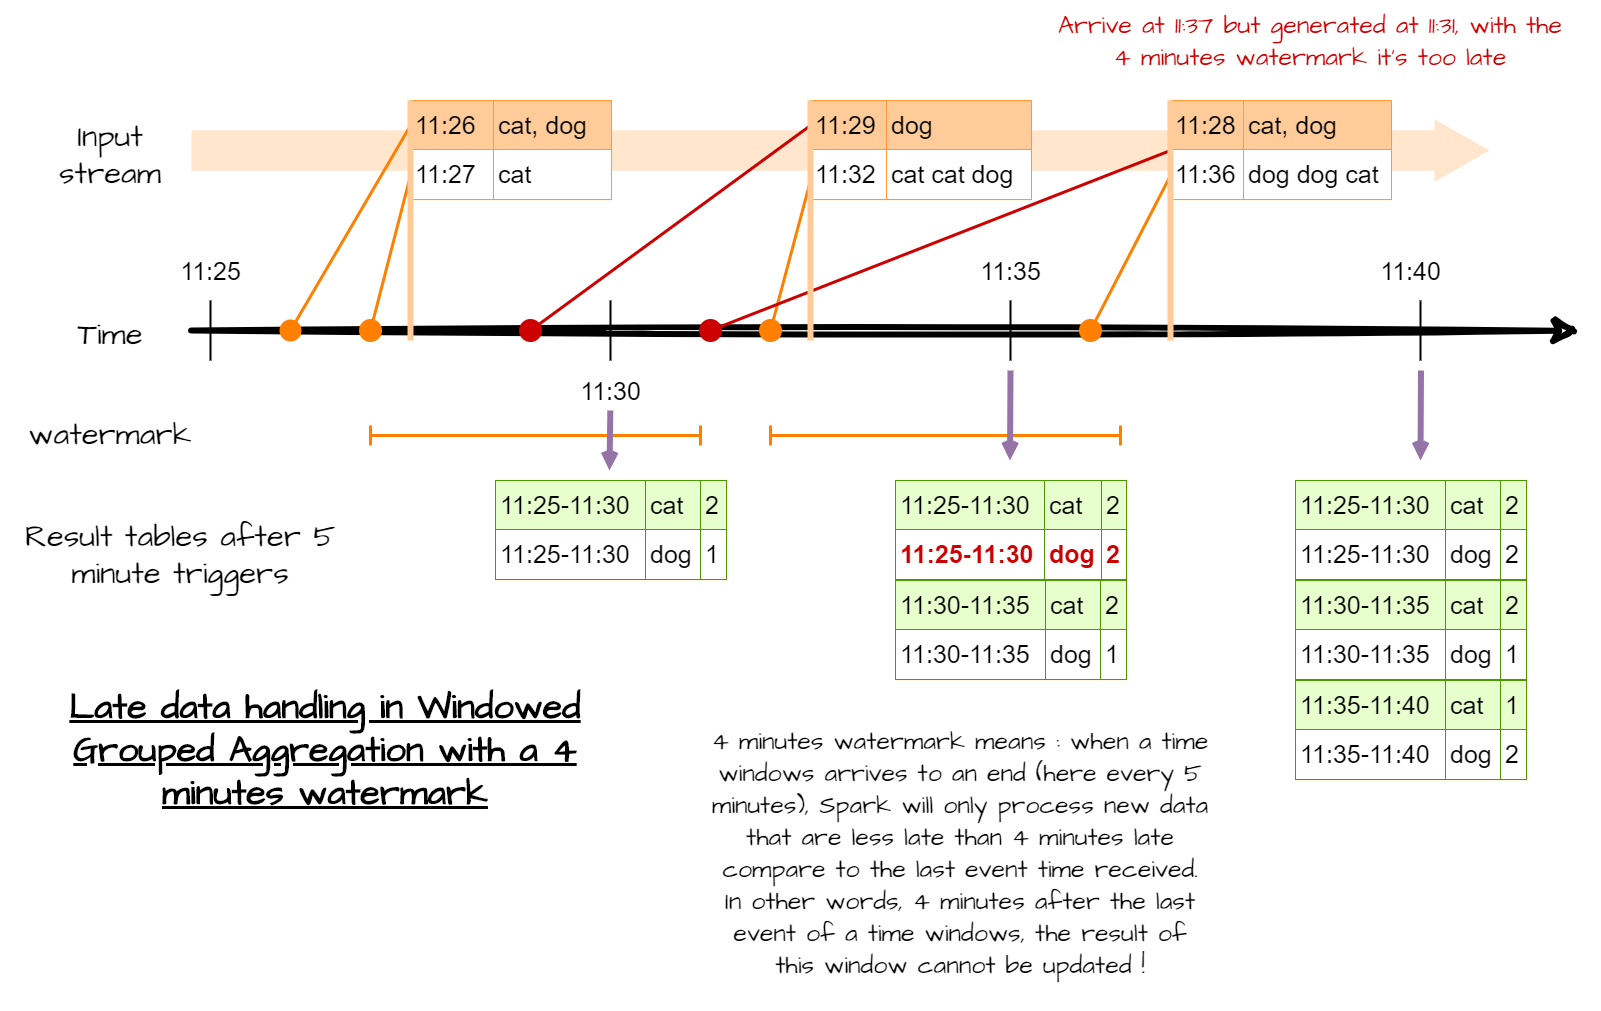

*Figure 7 : Time-event processing with watermark*

To do so, you have to define column as watermark and a the max delay.
You have to use the `withWatermark(column, max_delay)` method.

``` python
# Need some import
from pyspark.sql.functions import window, col

# word count + classic time window
df_with_event_time.withWatermark(df_with_event_time.event_time, "4 minutes")\
.groupBy(
    window(df_with_event_time.event_time, "5 minutes"),
    df_with_event_time.word).count()

# word count + sliding time window
df_with_event_time.withWatermark(df_with_event_time.event_time, "4 minutes")\
.groupBy(
    window(df_with_event_time.event_time, "10 minutes", "5 minutes"),
    df_with_event_time.word).count()
```

Be careful, the watermark field cannot be a nested field
([link](https://www.waitingforcode.com/apache-spark-structured-streaming/nested-fields-dropduplicates-watermark-apache-spark-structured-streaming/read))

#### ✍ Handling late data with watermarks ⏳

-   Count the number of event with a 10 seconds time window (use the
    `created_at` column) with a 5 seconds watermark
-   Count the number of event by hashtag with a 30 seconds time window
    with a 1 minute watermark
-   Count the number of event post by verified user with a 10 seconds
    time window sliding every 5 seconds with 25 seconds watermark. Write
    the the result in a file sorted in S3.

## For more details

-   [Spark official
    documentation](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#input-sources)
-   ZAHARIA, B. C. M. (2018). *Spark: the Definitive Guide*. , O’Reilly
    Media, Inc. https://proquest.safaribooksonline.com/9781491912201
-   https://databricks.com/blog/2018/03/13/introducing-stream-stream-joins-in-apache-spark-2-3.html
-   https://databricks.com/blog/2016/07/28/structured-streaming-in-apache-spark.html
-   https://databricks.com/blog/2015/07/30/diving-into-apache-spark-streamings-execution-model.html

------------------------------------------------------------------------

**DO NOT FORGET TO TURN YOUR CLUSTER OFF A THE END OF THIS TUTORIAL!**